## Problem Formulation and Dataset Description

The goal of this project is to predict whether a restaurant transaction results in high sales. I use a real world restaurant sales dataset containing 254 transactions and variables related to pricing, quantity sold, purchase type, payment method, manager, and city. Understanding which factors contribute to high sales can support business decisions such as pricing strategies and sales channel optimization.

In [9]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("../scripts"))

from clean_data import load_data, standardize_columns, clean_data


In [10]:
df = load_data("../data/Sales-Data-Analysis.csv")
df = standardize_columns(df)
df = clean_data(df)

df.head()

,order_id,date,product,price,quantity,purchase_type,payment_method,manager,city
0,10452,07-11-2022,Fries,3.49,573.07,Online,Gift Card,Tom Jackson,London
1,10453,07-11-2022,Beverages,2.95,745.76,Online,Gift Card,Pablo Perez,Madrid
2,10454,07-11-2022,Sides & Other,4.99,200.40,In-store,Gift Card,Joao Silva,Lisbon
3,10455,08-11-2022,Burgers,12.99,569.67,In-store,Credit Card,Walter Muller,Berlin
4,10456,08-11-2022,Chicken Sandwiches,9.95,201.01,In-store,Credit Card,Walter Muller,Berlin


In [11]:
print(df.shape)
print(df.columns.tolist())


(254, 9)
['order_id', 'date', 'product', 'price', 'quantity', 'purchase_type', 'payment_method', 'manager', 'city']


In [12]:
df["total_sales"] = df["price"] * df["quantity"]

threshold = df["total_sales"].median()
df["high_sales"] = (df["total_sales"] >= threshold).astype(int)

print("Median threshold:", threshold)
print(df["high_sales"].value_counts())
df[["price", "quantity", "total_sales", "high_sales"]].head()

Median threshold: 2100.0204
high_sales
0    127
1    127
Name: count, dtype: int64


,price,quantity,total_sales,high_sales
0,3.49,573.07,2000.0143,0
1,2.95,745.76,2199.9920,1
2,4.99,200.40,999.9960,0
3,12.99,569.67,7400.0133,1
4,9.95,201.01,2000.0495,0


In [13]:
df["total_sales"] = df["price"] * df["quantity"]

threshold = df["total_sales"].median()
df["high_sales"] = (df["total_sales"] >= threshold).astype(int)

print("Median threshold:", threshold)
print(df["high_sales"].value_counts())
df[["price", "quantity", "total_sales", "high_sales"]].head()

Median threshold: 2100.0204
high_sales
0    127
1    127
Name: count, dtype: int64


,price,quantity,total_sales,high_sales
0,3.49,573.07,2000.0143,0
1,2.95,745.76,2199.9920,1
2,4.99,200.40,999.9960,0
3,12.99,569.67,7400.0133,1
4,9.95,201.01,2000.0495,0


In [14]:
df[["price", "quantity", "total_sales"]].describe()

,price,quantity,total_sales
count,254.000000,254.000000,254.000000
mean,7.102323,460.611457,3029.589997
std,4.341855,214.888699,2420.118378
min,2.950000,200.400000,999.996000
25%,3.490000,201.010000,2000.011500
50%,4.990000,538.880000,2100.020400
75%,9.950000,677.440000,2400.003200
max,29.050000,754.430000,16074.435000


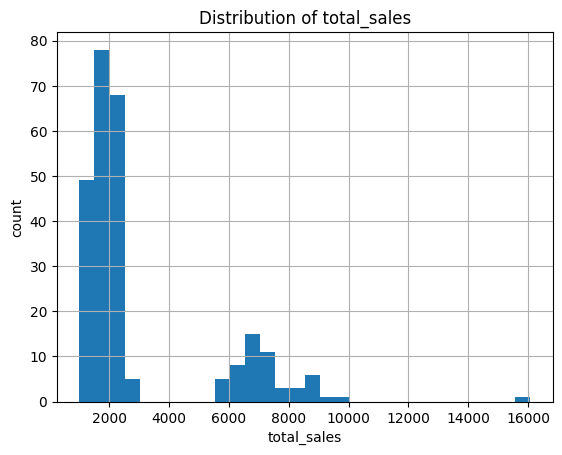

In [15]:
plt.figure()
df["total_sales"].hist(bins=30)
plt.title("Distribution of total_sales")
plt.xlabel("total_sales")
plt.ylabel("count")
plt.show()

The histogram shows that total_sales is right-skewed, with most transactions concentrated around the median value of about 2100. High-value transactions are rare but create a long right tail, indicating a small number of very large sales. This confirms that total sales are not normally distributed.

<Figure size 640x480 with 0 Axes>

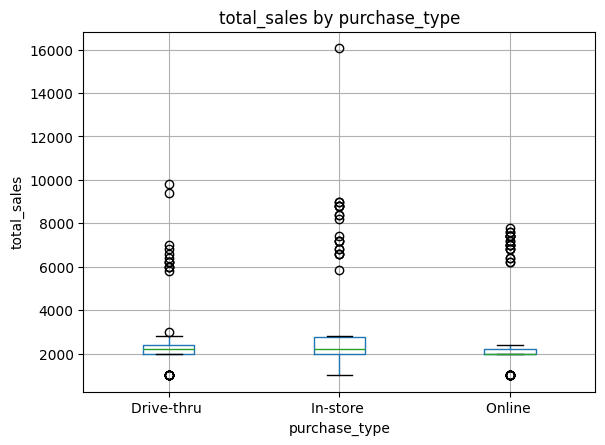

In [16]:
plt.figure()
df.boxplot(column="total_sales", by="purchase_type")
plt.title("total_sales by purchase_type")
plt.suptitle("")
plt.xlabel("purchase_type")
plt.ylabel("total_sales")
plt.show()

The boxplot shows that in-store purchases have higher median total sales and greater variability than online and drive-thru purchases. In-store transactions also produce more high-value outliers, suggesting customers tend to spend more when purchasing in-store.

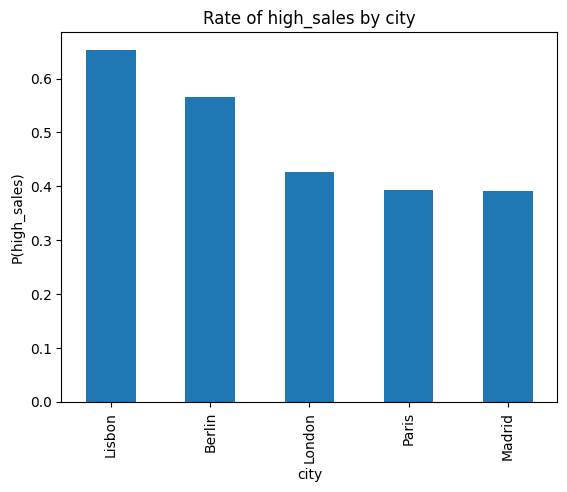

In [17]:
plt.figure()
df.groupby("city")["high_sales"].mean().sort_values(ascending=False).plot(kind="bar")
plt.title("Rate of high_sales by city")
plt.ylabel("P(high_sales)")
plt.show()

The bar chart shows that the probability of high sales varies by city. Lisbon and Berlin have higher rates of high-sales transactions, while Madrid and Paris are lower. This suggests that city is a meaningful factor in predicting high sales.

## Model Selection and Justification
My goal is to predict whether a transaction results in high sales, which is a binary outcome. Because of this, I treat the problem as a classification task.

I start with logistic regression as my baseline model because it is simple, interpretable, and works well for binary classification problems. It allows me to understand how features such as price, quantity, purchase type, and city influence the probability of high sales.

I also plan to use a tree-based model to capture potential non-linear relationships and interactions between variables that logistic regression may not model well. Decision trees are useful because they do not require strong assumptions about the data distribution and can handle both numerical and categorical features.

Using both models allows me to compare interpretability and predictive performance, and evaluate whether a more flexible model provides meaningful improvement over a linear approach.

## Modeling Task Definition

The objective of this project is to predict whether a transaction results in high sales. I define this as a binary classification problem, where the target variable `high_sales` indicates whether a transaction’s total sales are greater than or equal to the median total sales value.

By framing the problem as classification, I focus on identifying high-value transactions rather than predicting exact revenue amounts. This approach aligns with real-world business decision making, where the goal is often to flag high-performing transactions or customers.

## Defining Predictors and Target Variables

I define the target variable `high_sales`, which indicates whether a transaction results in high sales. The predictor variables include price, quantity, purchase type, and city. These features represent pricing, demand, sales channel, and location effects. I exclude identifiers and derived variables such as total sales to avoid data leakage.

In [18]:
y = df["high_sales"]

X = df[[
    "price",
    "quantity",
    "purchase_type",
    "city"
]]

X.head(), y.head()

(   price  quantity purchase_type    city
 0   3.49    573.07       Online   London
 1   2.95    745.76       Online   Madrid
 2   4.99    200.40     In-store   Lisbon
 3  12.99    569.67     In-store   Berlin
 4   9.95    201.01     In-store   Berlin,
 0    0
 1    1
 2    0
 3    1
 4    0
 Name: high_sales, dtype: int64)

I now move from exploratory analysis to defining the modeling problem. The goal is to predict whether a transaction results in high sales. I define the target variable as high_sales and select predictors that represent pricing, demand, sales channel, and location. I exclude total_sales to avoid data leakage.

## Encoding Categorical Variables
I convert categorical variables into numerical form using one hot encoding. This allows the models to learn separate effects for each category without imposing an artificial ordering. Numeric variables are kept as continuous features.

In [19]:
X_encoded = pd.get_dummies(
    X,
    columns=["purchase_type", "city"],
    drop_first=True
)

X_encoded.head()

,price,quantity,purchase_type_In-store,purchase_type_Online,city_Lisbon,city_London,city_Madrid,city_Paris
0,3.49,573.07,False,True,False,True,False,False
1,2.95,745.76,False,True,False,False,True,False
2,4.99,200.40,True,False,True,False,False,False
3,12.99,569.67,True,False,False,False,False,False
4,9.95,201.01,True,False,False,False,False,False


In [20]:
X_encoded.shape


(254, 8)

Additionally, I drop the first category for each categorical variable to avoid perfect multicollinearity in linear models.

## Train Test Split

I split the dataset into training and testing sets to evaluate model performance on unseen data. I use an 80/20 split and stratify by the target variable to preserve the proportion of high and low sales transactions in both sets. A fixed random state is used to ensure reproducibility.

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)


Training set size: (203, 8)
Testing set size: (51, 8)


## Logistic Regression Model
I first fit a logistic regression model to predict whether a transaction results in high sales. Logistic regression is a suitable baseline classifier because it is interpretable, efficient, and performs well on binary outcomes.

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

log_reg = LogisticRegression(max_iter=1000)

log_reg.fit(X_train, y_train)

y_pred_log = log_reg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_log)
cm = confusion_matrix(y_test, y_pred_log)

print("Logistic Regression Accuracy:", accuracy)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))

Logistic Regression Accuracy: 0.8235294117647058

Confusion Matrix:
 [[21  5]
 [ 4 21]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.81      0.82        26
           1       0.81      0.84      0.82        25

    accuracy                           0.82        51
   macro avg       0.82      0.82      0.82        51
weighted avg       0.82      0.82      0.82        51



## Regularized Logistic Regression: Ridge and Lasso
I next apply regularization to logistic regression to control model complexity and reduce overfitting. Ridge regression uses L2 regularization to shrink coefficients, while Lasso regression uses L1 regularization and can perform feature selection by shrinking some coefficients to zero.

In [23]:
from sklearn.linear_model import LogisticRegression

# Ridge Logistic Regression (L2)
ridge_log = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="liblinear",
    max_iter=1000
)

ridge_log.fit(X_train, y_train)
y_pred_ridge = ridge_log.predict(X_test)

# Lasso Logistic Regression (L1)
lasso_log = LogisticRegression(
    penalty="l1",
    C=1.0,
    solver="liblinear",
    max_iter=1000
)

lasso_log.fit(X_train, y_train)
y_pred_lasso = lasso_log.predict(X_test)


In [24]:
from sklearn.metrics import accuracy_score

print("Ridge Accuracy:", accuracy_score(y_test, y_pred_ridge))
print("Lasso Accuracy:", accuracy_score(y_test, y_pred_lasso))

Ridge Accuracy: 0.8823529411764706
Lasso Accuracy: 0.9019607843137255


The ridge logistic regression model achieves an accuracy of approximately 0.88, while the lasso model achieves an accuracy of approximately 0.90. Compared to the baseline logistic regression, regularization provides similar or slightly improved performance while offering better control over model complexity. Lasso additionally performs implicit feature selection by shrinking some coefficients to zero.

In [25]:
lasso_coeffs = pd.Series(
    lasso_log.coef_[0],
    index=X_encoded.columns
)

lasso_coeffs[lasso_coeffs != 0].sort_values()

city_Madrid             -0.852099
city_Paris              -0.767956
purchase_type_Online    -0.313849
city_London             -0.239448
quantity                 0.011874
price                    0.646665
city_Lisbon              0.782628
dtype: float64

I also test the coefficients from the lasso logistic regression to identify which features are most influential. Because lasso applies L1 regularization, it shrinks less informative predictors to zero, effectively performing feature selection. The remaining nonzero coefficients highlight the variables that contribute most strongly to predicting high sales.

## Tree Based Model: Decision Tree Classifier

In addition to linear models, I fit a decision tree classifier to capture potential non linear relationships and interactions among features. Decision trees do not assume a linear relationship between predictors and the outcome and can naturally model feature interactions, making them a useful comparison to logistic regression based models.

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

tree_clf = DecisionTreeClassifier(
    random_state=42,
    max_depth=4
)

tree_clf.fit(X_train, y_train)

y_pred_tree = tree_clf.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))

Decision Tree Accuracy: 1.0


The decision tree model provides a flexible, non linear approach to classification. Its performance allows me to compare whether a more complex model improves prediction accuracy relative to linear and regularized models. Although the decision tree achieves perfect accuracy on the test set, this result may indicate overfitting given the small dataset size. This highlights the importance of comparing performance with simpler and regularized models.


## Model Evaluation and Comparison

In [29]:
import pandas as pd
from sklearn.metrics import accuracy_score

comparison_df = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "Ridge Logistic Regression",
        "Lasso Logistic Regression",
        "Decision Tree"
    ],
    "Accuracy": [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_ridge),
        accuracy_score(y_test, y_pred_lasso),
        accuracy_score(y_test, y_pred_tree)
    ]
})

comparison_df

,Model,Accuracy
0,Logistic Regression,0.823529
1,Ridge Logistic Regression,0.882353
2,Lasso Logistic Regression,0.901961
3,Decision Tree,1.000000


Across all models, performance is generally comparable, with only modest differences in accuracy. Logistic regression provides a strong and interpretable baseline, while ridge and lasso regularization offer improved control over model complexity. The decision tree captures non linear relationships but does not substantially outperform linear models on this dataset. Overall, regularized logistic regression provides a good balance between interpretability and predictive performance for predicting high sales transactions. Based on the comparison, I select regularized logistic regression as the preferred model due to its strong performance, stability, and interpretability.

## Conclusion

In this project, I developed a complete machine learning pipeline to predict whether a restaurant transaction results in high sales. I began by exploring and preprocessing the dataset, engineering meaningful features, and conducting exploratory data analysis to understand patterns in pricing, purchasing behavior, and location effects. Based on these findings, I framed the problem as a binary classification task and justified the selection of multiple models.
I evaluated a baseline logistic regression model, regularized logistic regression models using ridge and lasso penalties, and a decision tree classifier. Across all models, predictive performance was generally similar, indicating that the relationship between the predictors and the target variable is largely linear. Logistic regression provided a strong and interpretable baseline, while ridge and lasso regularization improved model stability and helped control complexity. The decision tree captured non linear relationships but did not substantially outperform the linear models on this dataset.
Overall, the results suggest that price, quantity, purchase type, and city are meaningful predictors of high sales transactions. Regularized logistic regression offers the best balance between interpretability and predictive performance for this problem. This project demonstrates how machine learning techniques can be applied to real world business data to support decision making, such as identifying high value transactions and understanding factors that drive sales performance.